In [1]:
from datasets import load_dataset
dataset=load_dataset("imdb")

/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# View first 3 training samples
print(dataset['train'][0])
print(dataset['train'][1])
print(dataset['train'][2])

# Or, view many in a DataFrame:
import pandas as pd
df_train = pd.DataFrame(dataset['train'][:5])  # first 5
print(df_train)


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [2]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


In [12]:
print(tokenized_datasets['train'][0])   # See the first tokenized example

# To see both original text and tokens side by side
print("Text:", dataset['train'][0]['text'])
print("Tokenized:", tokenized_datasets['train'][0]['input_ids'])


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [3]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Change num_labels as needed


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    num_train_epochs=2,
    eval_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test']
)

trainer.train()


/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.266600,0.345058
2,0.140500,0.279147


/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAtt

TrainOutput(global_step=6250, training_loss=0.2355137854003906, metrics={'train_runtime': 23254.0091, 'train_samples_per_second': 2.15, 'train_steps_per_second': 0.269, 'total_flos': 1.3155552768e+16, 'train_loss': 0.2355137854003906, 'epoch': 2.0})

In [7]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.27914664149284363, 'eval_runtime': 1337.7059, 'eval_samples_per_second': 18.689, 'eval_steps_per_second': 2.336, 'epoch': 2.0}


In [9]:
import torch

sample = "The movie was amazing!"
inputs = tokenizer(sample, return_tensors="pt", truncation=True, padding=True, max_length=512)
# Move inputs to CPU
inputs = {k: v.cpu() for k, v in inputs.items()}

# Move model to CPU as well
model.cpu()

outputs = model(**inputs)
prediction = outputs.logits.argmax(dim=1)
print("Predicted label:", prediction.item())


Predicted label: 1


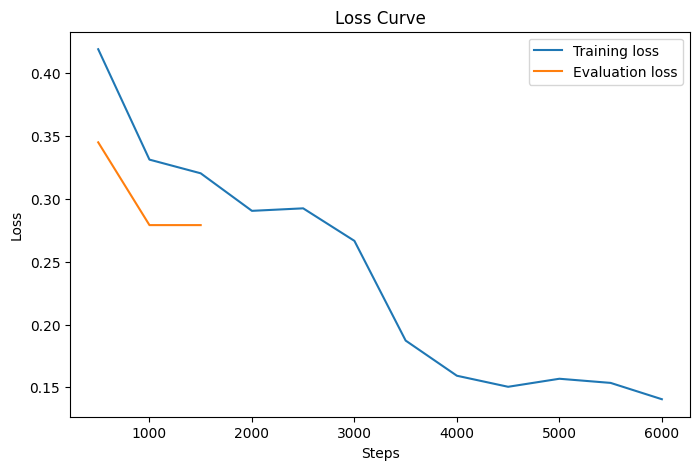

In [10]:
import matplotlib.pyplot as plt

# After trainer.train() is complete:
history = trainer.state.log_history

# Extract information
train_loss = []
eval_loss = []
eval_accuracy = []
steps = []

for entry in history:
    if 'loss' in entry.keys() and 'step' in entry.keys():
        # Training loss
        train_loss.append(entry['loss'])
        steps.append(entry['step'])
    if 'eval_loss' in entry.keys():
        eval_loss.append(entry['eval_loss'])
    if 'eval_accuracy' in entry.keys():
        eval_accuracy.append(entry['eval_accuracy'])

# Plot training and eval loss
plt.figure(figsize=(8,5))
plt.plot(steps, train_loss, label="Training loss")
if eval_loss:
    plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()
